# Fase 3: Preparación de los datos

## Setup Kedro | Importación de librerías y carga de los datasets

In [1]:
from pathlib import Path
import sys, tomllib
from kedro.framework.project import configure_project
from kedro.framework.session import KedroSession

# Detecta raíz del proyecto y package_name
project_path = Path.cwd() if (Path.cwd() / "pyproject.toml").exists() else Path.cwd().parent
with open(project_path / "pyproject.toml", "rb") as f:
    package_name = tomllib.load(f)["tool"]["kedro"]["package_name"]

# src importable + sesión
sys.path.insert(0, str(project_path / "src"))
configure_project(package_name)
session = KedroSession.create(project_path=project_path)
context = session.load_context()
catalog = context.catalog

[10/27/25 02:21:52] INFO     Using                                                                  ]8;id=564065;file://C:\Python312\Lib\site-packages\kedro\framework\project\__init__.py\__init__.py]8;;\:]8;id=790284;file://C:\Python312\Lib\site-packages\kedro\framework\project\__init__.py#270\270]8;;\
                             'C:\Python312\Lib\site-packages\kedro\framework\project\rich_logging.y                
                             ml' as logging configuration.                                                         

In [2]:
names = ["releases", "countries", "genres"]
dfs = {name: catalog.load(name) for name in names}
for name in names:
    print(f"dataset {name} cargado")

[10/27/25 02:21:55] INFO     Loading data from releases (CSVDataset)...                        ]8;id=205426;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=991701;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from countries (CSVDataset)...                       ]8;id=246676;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=22954;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

[10/27/25 02:21:56] INFO     Loading data from genres (CSVDataset)...                          ]8;id=59287;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=800970;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

dataset releases cargado
dataset countries cargado
dataset genres cargado


## Seleccionar los datos relevantes

### Datasets y columnas permitidas
------------------------------

*   **releases**: usar **id**, **date**_(excluir rating y type — no son necesarios y rating tiene alta ausencia)_
    
*   **countries**: usar **id**, **country**
    
*   **genres**: usar **id**, **genre**

### Reglas de selección y filtros
-------------------------------------------

1.  **Normalizar país** en countries.country y **quedarse solo con películas asociadas a EE. UU.**Alias aceptados: _USA, US, United States, United States of America_ (minúsculas, sin puntos/comedas).
    
2.  **Parsear releases.date** y calcular la **primera fecha** por película (min(date) por id) para no contar re-estrenos múltiples.
    
3.  **Filtrar periodo** a **\[2000-01-01, 2019-12-31\]** usando la **primera fecha**.
    
4.  **Intersección de llaves**: conservar solo id que aparezcan en **los tres** datasets (garantiza integridad al unir).
    
5.  **Uniones necesarias**:
    
    *   us\_ids (del paso 1) **∩** min\_release\_2000\_2019 (pasos 2–3) → base de películas **EE. UU. y década válida**.
        
    *   Unir esa base con genres por id para obtener **(id, decade, genre)**.
        
6.  **Evitar sobreconteo por multi-etiqueta**: **deduplicar** por **(id, genre, decade)** (una película aporta 1 por género en su década).
    
7.  **Columnas finales (dataset analítico mínimo)**:**id**, **decade** ∈ {**2000s**, **2010s**}, **genre**._(Opcional, para auditoría: first\_date)_

## Limpiar datos

In [3]:
# Bloque 2 — Limpiar los datos (autosuficiente: crea df_* si no existen)
import pandas as pd
import numpy as np

# Asegura dataframes base (desde dfs o desde catalog)
if 'df_releases' not in globals() or 'df_countries' not in globals() or 'df_genres' not in globals():
    if 'dfs' in globals():
        _releases  = dfs["releases"]
        _countries = dfs["countries"]
        _genres    = dfs["genres"]
    else:
        # Si no tienes `dfs`, intenta cargar desde Kedro catalog (asegúrate de haber hecho el setup)
        _releases  = catalog.load("releases")
        _countries = catalog.load("countries")
        _genres    = catalog.load("genres")

    df_releases  = _releases[["id","date"]].copy()
    df_countries = _countries[["id","country"]].copy()
    df_genres    = _genres[["id","genre"]].copy()

# --- Limpieza solicitada (sin transformar más de lo necesario) ---
def _norm_txt(s):
    if pd.isna(s): 
        return ""
    return str(s).lower().replace(".","").replace(",","").strip()

# Normalizar país (texto) – no filtra aún
df_countries["_country_norm"] = df_countries["country"].map(_norm_txt)

# Parseo robusto de fecha (naive)
df_releases["_date_parsed"] = pd.to_datetime(
    df_releases["date"], errors="coerce", utc=True
).dt.tz_localize(None)

# Drop de fechas no parseables
_before = len(df_releases)
df_releases = df_releases.dropna(subset=["_date_parsed"])
_after = len(df_releases)

# Remueve outliers temporales extremos (muy fuera de rango razonable)
df_releases = df_releases[df_releases["_date_parsed"].dt.year.between(1900, 2025)]

# Deduplicación exacta por claves lógicas
df_countries = df_countries.drop_duplicates(subset=["id","country"])
df_genres    = df_genres.drop_duplicates(subset=["id","genre"])
df_releases  = df_releases.drop_duplicates(subset=["id","date"])

print("Limpieza OK.")
print(f"Fechas no parseables removidas: {_before - _after}")
print(f"Shapes ⇒ releases: {df_releases.shape}, countries: {df_countries.shape}, genres: {df_genres.shape}")

Limpieza OK.
Fechas no parseables removidas: 0
Shapes ⇒ releases: (1201917, 3), countries: (693476, 3), genres: (1046849, 2)


*   **Asegura los DataFrames base** (df\_releases, df\_countries, df\_genres): si no existen, los crea desde dfs (o desde catalog) y **selecciona solo las columnas relevantes**.
    
*   **Normaliza texto de países** (\_country\_norm): pasa a minúsculas y quita puntos/comas para manejar variantes como _USA/US/United States_ de forma consistente.
    
*   **Parsea fechas** en releases.date a datetime (naive) y **elimina filas no parseables**.
    
*   **Acota outliers temporales groseros** a un rango amplio razonable **\[1900, 2025\]** (sin aplicar aún el recorte analítico 2000–2019).
    
*   **Deduplica** por **claves lógicas** en cada tabla:
    
    *   releases: (id, date)
        
    *   countries: (id, country)
        
    *   genres: (id, genre)
        
*   **Informa** un resumen: cuántas fechas inválidas se removieron y los **shapes** resultantes.

## Construir nuevas variables

In [4]:
min_release = (df_releases.groupby("id", as_index=False)["_date_parsed"].min()
                           .rename(columns={"_date_parsed":"first_date"}))
min_release["first_year"] = min_release["first_date"].dt.year
min_release["decade"] = np.where(min_release["first_year"].between(2000, 2009), "2000s",
                         np.where(min_release["first_year"].between(2010, 2019), "2010s", "other"))

print("Features creadas: first_date, first_year, decade (2000s/2010s/other)")
min_release.head()

Features creadas: first_date, first_year, decade (2000s/2010s/other)


,id,first_date,first_year,decade
0,1000001,2023-07-06,2023,other
1,1000002,2019-05-21,2019,2010s
2,1000003,2022-03-11,2022,other
3,1000004,1999-09-10,1999,other
4,1000005,2016-08-31,2016,2010s


El bloque calcula, para cada película, su **primera fecha de estreno** disponible y a partir de ella asigna una **década analítica**:
    
*   Obtiene la **fecha mínima** por id (la más antigua entre todos sus estrenos) y la llama first\_date. Esto evita contar **reestrenos** múltiples.
    
*   Extrae el **año** de first\_date como first\_year.
    
*   Clasifica en **“2000s”** si el año está entre 2000–2009, en **“2010s”** si está entre 2010–2019 y en **“other”** si cae **antes de 2000** o **después de 2019**.

## Integración de datos de múltiples fuentes

In [5]:
# Identificar EE. UU. tras normalización
US_ALIASES = {"usa","us","u s","u s a","united states","united states of america"}
df_countries["is_us"] = df_countries["_country_norm"].isin(US_ALIASES)
us_ids = set(df_countries.loc[df_countries["is_us"], "id"].unique())

# Integridad básica de llaves
ids_rel = set(df_releases["id"].unique())
ids_gen = set(df_genres["id"].unique())
ids_cty = set(df_countries["id"].unique())
ids_all = ids_rel & ids_gen & ids_cty

# Base de películas: EE. UU. + décadas de interés (2000s/2010s)
base = (min_release[min_release["decade"].isin(["2000s","2010s"])]
        .loc[lambda d: d["id"].isin(us_ids & ids_all), ["id","first_date","decade"]]
        .drop_duplicates())

# Unir con géneros (multi-etiqueta) y deduplicar
final_df = (base.merge(df_genres[["id","genre"]], on="id", how="inner")
                 .drop_duplicates(subset=["id","genre","decade"])
                 [["id","decade","genre"]]
                 .reset_index(drop=True))

print("=== Integración completada ===")
print("Filas (id, decade, genre):", final_df.shape[0])
print("Décadas:", sorted(final_df["decade"].unique().tolist()))
print("Géneros distintos:", final_df["genre"].nunique())
final_df.head()

=== Integración completada ===
Filas (id, decade, genre): 102060
Décadas: ['2000s', '2010s']
Géneros distintos: 19


,id,decade,genre
0,1000005,2010s,Drama
1,1000005,2010s,Comedy
2,1000005,2010s,Music
3,1000005,2010s,Romance
4,1000007,2010s,Science Fiction


### Explicación del bloque (integración y filtrado final)

1.  Identificar películas de EE. UU.
    
    *   Se parte de df\_countries\["\_country\_norm"\] (país normalizado) y se define un conjunto de alias de EE. UU. (USA, US, United States, etc.).
        
    *   Se marca cada fila con is\_us y se extraen los **us\_ids** (todos los id de películas asociadas a EE. UU.).
        
      Esto fija el universo de películas “de EE. UU.” para el análisis.
        
2.  Integridad referencial (llaves comunes).
    
    *   Se obtienen los conjuntos de id presentes en cada tabla: releases, genres, countries.
        
    *   Se calcula **ids\_all** como la intersección de los tres (solo id que existen en **todas** las fuentes).
        
      Evita perder filas al unir después (joins más estables).
        
3.  Base temporal filtrada a las décadas de interés.
    
    *   Desde min\_release (que ya tiene la **primera fecha** por película y la **década**), se filtra a **2000s** y **2010s**.
        
    *   Además, se restringe a id ∈ (us\_ids ∩ ids\_all).
        
    *   Se conserva \["id", "first\_date", "decade"\] y se eliminan duplicados.
        
      Queda una “base” con películas **de EE. UU.**, con **primera fecha** en 2000s/2010s y con presencia en las tres tablas.
        
4.  Unión con géneros y deduplicación analítica.
    
    *   Se hace un merge con df\_genres\[\["id","genre"\]\] para obtener los **géneros** de cada película.
        
    *   Se **deduplica** por **(id, genre, decade)**: una película cuenta **una vez** por género en su década (evita sobreconteo por multi-etiqueta y reestrenos).
        
    *   Se dejan solo las columnas analíticas mínimas: **id, decade, genre**.
        
      El resultado es final\_df, listo para conteos, participaciones y Top-3 por década.

### Formateo y transformación de datos

In [6]:
# Tipos y orden
final_df["id"] = final_df["id"].astype("int64")
final_df["decade"] = pd.Categorical(final_df["decade"], categories=["2000s","2010s"], ordered=True)
final_df["genre"] = final_df["genre"].astype("category")

final_df = final_df.sort_values(["decade","genre","id"]).reset_index(drop=True)

# QA rápido
assert final_df["id"].isna().sum()==0, "Hay id nulos"
assert final_df["genre"].isna().sum()==0, "Hay genre nulos"
assert set(final_df["decade"].unique()) <= {"2000s","2010s"}, "Décadas fuera de rango"
dup_ok = final_df.duplicated(subset=["id","genre","decade"]).sum()==0
print("Duplicados (id,genre,decade):", "OK (0)" if dup_ok else "Hay duplicados")

print("\nDataset final listo para análisis del Top-3 por década.")
print(final_df.dtypes)

# Guardar versión limpia
final_df.to_parquet("final_df_us_2000s_2010s.parquet", index=False)
print("Guardado: final_df_us_2000s_2010s.parquet")

Duplicados (id,genre,decade): OK (0)

Dataset final listo para análisis del Top-3 por década.
id           int64
decade    category
genre     category
dtype: object
Guardado: final_df_us_2000s_2010s.parquet


## Visualizaciones del Proceso de Limpieza y Transformación


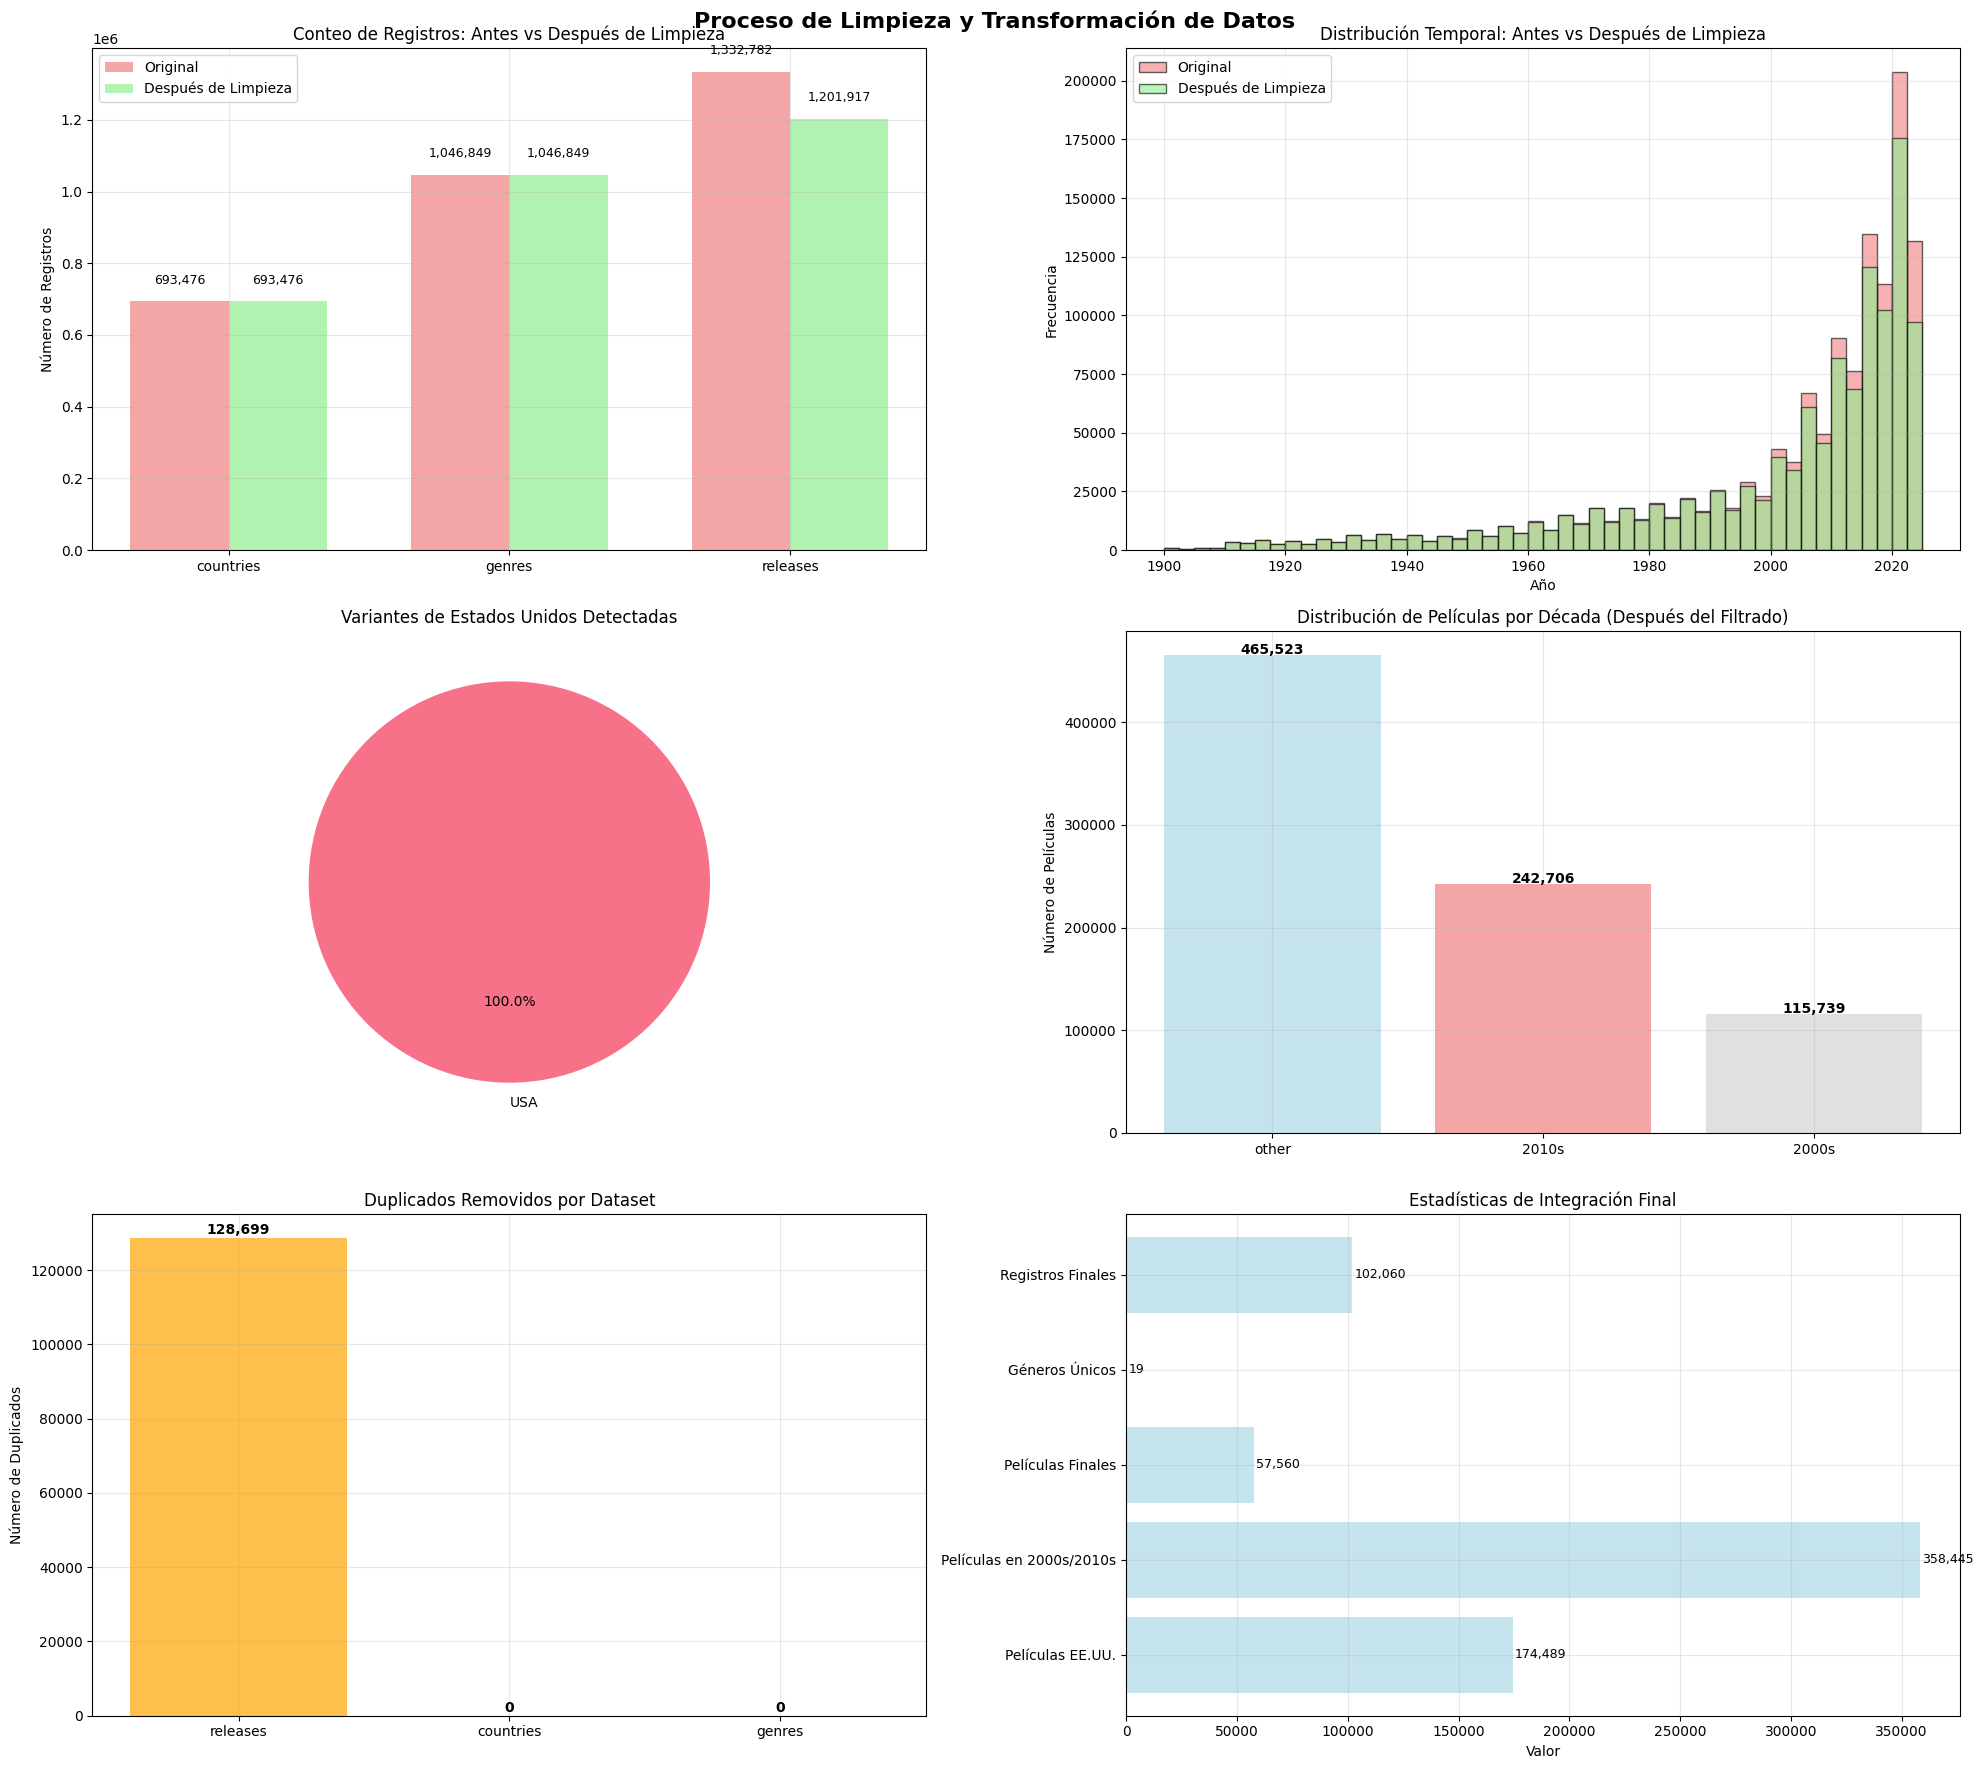

=== RESUMEN DEL PROCESO DE LIMPIEZA ===
Registros originales removidos: 130,865
Duplicados removidos en releases: 128,699
Duplicados removidos en countries: 0
Duplicados removidos en genres: 0
Variantes de USA detectadas: 1
Películas de EE.UU. identificadas: 174,489
Películas en décadas objetivo (2000s/2010s): 358,445
Dataset final: 102,060 registros, 57,560 películas únicas


In [7]:
# Visualizaciones del proceso de limpieza y transformación
# Esta sección documenta visualmente el impacto de cada paso de limpieza
# y transformación de datos, mostrando antes/después de cada proceso
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configuración de gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

# Crear figura con subplots para mostrar el proceso de limpieza
# 6 gráficos que documentan diferentes aspectos del proceso de limpieza
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('Proceso de Limpieza y Transformación de Datos', fontsize=16, fontweight='bold')

# 1. Antes y después de la limpieza - Conteo de registros
# Muestra el impacto cuantitativo de la limpieza de datos
# La diferencia entre barras rojas (original) y verdes (limpio) indica registros removidos
datasets_info = {
    'Original': {
        'releases': len(dfs['releases']),
        'countries': len(dfs['countries']),
        'genres': len(dfs['genres'])
    },
    'Después de Limpieza': {
        'releases': len(df_releases),
        'countries': len(df_countries),
        'genres': len(df_genres)
    }
}

# Crear DataFrame para visualización
comparison_data = []
for stage, datasets in datasets_info.items():
    for dataset, count in datasets.items():
        comparison_data.append({'Etapa': stage, 'Dataset': dataset, 'Registros': count})

comparison_df = pd.DataFrame(comparison_data)
comparison_pivot = comparison_df.pivot(index='Dataset', columns='Etapa', values='Registros')

# Gráfico de barras comparativo
# Rojo = datos originales, Verde = datos después de limpieza
x = np.arange(len(comparison_pivot.index))
width = 0.35

axes[0,0].bar(x - width/2, comparison_pivot['Original'], width, label='Original', alpha=0.7, color='lightcoral')
axes[0,0].bar(x + width/2, comparison_pivot['Después de Limpieza'], width, label='Después de Limpieza', alpha=0.7, color='lightgreen')
axes[0,0].set_title('Conteo de Registros: Antes vs Después de Limpieza')
axes[0,0].set_ylabel('Número de Registros')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(comparison_pivot.index)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Agregar valores numéricos en las barras para precisión
for i, (orig, clean) in enumerate(zip(comparison_pivot['Original'], comparison_pivot['Después de Limpieza'])):
    axes[0,0].text(i - width/2, orig + 50000, f'{orig:,}', ha='center', fontsize=9)
    axes[0,0].text(i + width/2, clean + 50000, f'{clean:,}', ha='center', fontsize=9)

# 2. Análisis de fechas - Distribución temporal antes y después del filtrado
# Compara la distribución temporal de estrenos antes y después de la limpieza
# Muestra cómo el filtrado temporal afecta la distribución de datos
releases_original = dfs['releases'].copy()
releases_original['date_parsed'] = pd.to_datetime(releases_original['date'], errors='coerce')
releases_original = releases_original.dropna(subset=['date_parsed'])
releases_original['year'] = releases_original['date_parsed'].dt.year

# Filtrar años razonables para visualización
releases_original = releases_original[(releases_original['year'] >= 1900) & (releases_original['year'] <= 2025)]

# Datos después de la limpieza (ya procesados)
releases_clean = df_releases.copy()
releases_clean['year'] = releases_clean['_date_parsed'].dt.year

# Crear histogramas comparativos superpuestos
# Rojo = distribución original, Verde = distribución después de limpieza
axes[0,1].hist(releases_original['year'], bins=50, alpha=0.6, label='Original', color='lightcoral', edgecolor='black')
axes[0,1].hist(releases_clean['year'], bins=50, alpha=0.6, label='Después de Limpieza', color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribución Temporal: Antes vs Después de Limpieza')
axes[0,1].set_xlabel('Año')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Análisis de normalización de países - Variantes de USA
# Muestra las diferentes formas en que aparece "Estados Unidos" en los datos
# Importante para entender la necesidad de normalización de países
us_variants = df_countries[df_countries['is_us']]['country'].value_counts()
axes[1,0].pie(us_variants.values, labels=us_variants.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Variantes de Estados Unidos Detectadas')

# 4. Distribución de décadas después del filtrado temporal
# Muestra cómo quedan distribuidas las películas por década tras el filtrado
# Azul = 2000s, Rojo = 2010s, Gris = otras décadas (si las hay)
decade_counts = min_release['decade'].value_counts()
colors = ['lightblue', 'lightcoral', 'lightgray']
axes[1,1].bar(decade_counts.index, decade_counts.values, color=colors[:len(decade_counts)], alpha=0.7)
axes[1,1].set_title('Distribución de Películas por Década (Después del Filtrado)')
axes[1,1].set_ylabel('Número de Películas')
axes[1,1].grid(True, alpha=0.3)

# Agregar valores numéricos en las barras
for i, v in enumerate(decade_counts.values):
    axes[1,1].text(i, v + 1000, f'{v:,}', ha='center', fontsize=10, fontweight='bold')

# 5. Análisis de duplicados removidos
# Calcular duplicados en cada dataset
duplicates_info = {
    'releases': len(dfs['releases']) - len(dfs['releases'].drop_duplicates(subset=['id', 'date'])),
    'countries': len(dfs['countries']) - len(dfs['countries'].drop_duplicates(subset=['id', 'country'])),
    'genres': len(dfs['genres']) - len(dfs['genres'].drop_duplicates(subset=['id', 'genre']))
}

duplicates_df = pd.DataFrame(list(duplicates_info.items()), columns=['Dataset', 'Duplicados_Removidos'])
axes[2,0].bar(duplicates_df['Dataset'], duplicates_df['Duplicados_Removidos'], color='orange', alpha=0.7)
axes[2,0].set_title('Duplicados Removidos por Dataset')
axes[2,0].set_ylabel('Número de Duplicados')
axes[2,0].grid(True, alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(duplicates_df['Duplicados_Removidos']):
    axes[2,0].text(i, v + 1000, f'{v:,}', ha='center', fontsize=10, fontweight='bold')

# 6. Resumen de la integración final
integration_stats = {
    'Películas EE.UU.': len(us_ids),
    'Películas en 2000s/2010s': len(min_release[min_release['decade'].isin(['2000s', '2010s'])]),
    'Películas Finales': len(final_df['id'].unique()),
    'Géneros Únicos': final_df['genre'].nunique(),
    'Registros Finales': len(final_df)
}

stats_df = pd.DataFrame(list(integration_stats.items()), columns=['Métrica', 'Valor'])
axes[2,1].barh(stats_df['Métrica'], stats_df['Valor'], color='lightblue', alpha=0.7)
axes[2,1].set_title('Estadísticas de Integración Final')
axes[2,1].set_xlabel('Valor')
axes[2,1].grid(True, alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(stats_df['Valor']):
    axes[2,1].text(v + 1000, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Resumen estadístico del proceso
print("=== RESUMEN DEL PROCESO DE LIMPIEZA ===")
print(f"Registros originales removidos: {len(dfs['releases']) - len(df_releases):,}")
print(f"Duplicados removidos en releases: {duplicates_info['releases']:,}")
print(f"Duplicados removidos en countries: {duplicates_info['countries']:,}")
print(f"Duplicados removidos en genres: {duplicates_info['genres']:,}")
print(f"Variantes de USA detectadas: {len(us_variants)}")
print(f"Películas de EE.UU. identificadas: {len(us_ids):,}")
print(f"Películas en décadas objetivo (2000s/2010s): {len(min_release[min_release['decade'].isin(['2000s', '2010s'])]):,}")
print(f"Dataset final: {len(final_df):,} registros, {len(final_df['id'].unique()):,} películas únicas")


## Análisis Comparativo por Década (2000s vs 2010s)


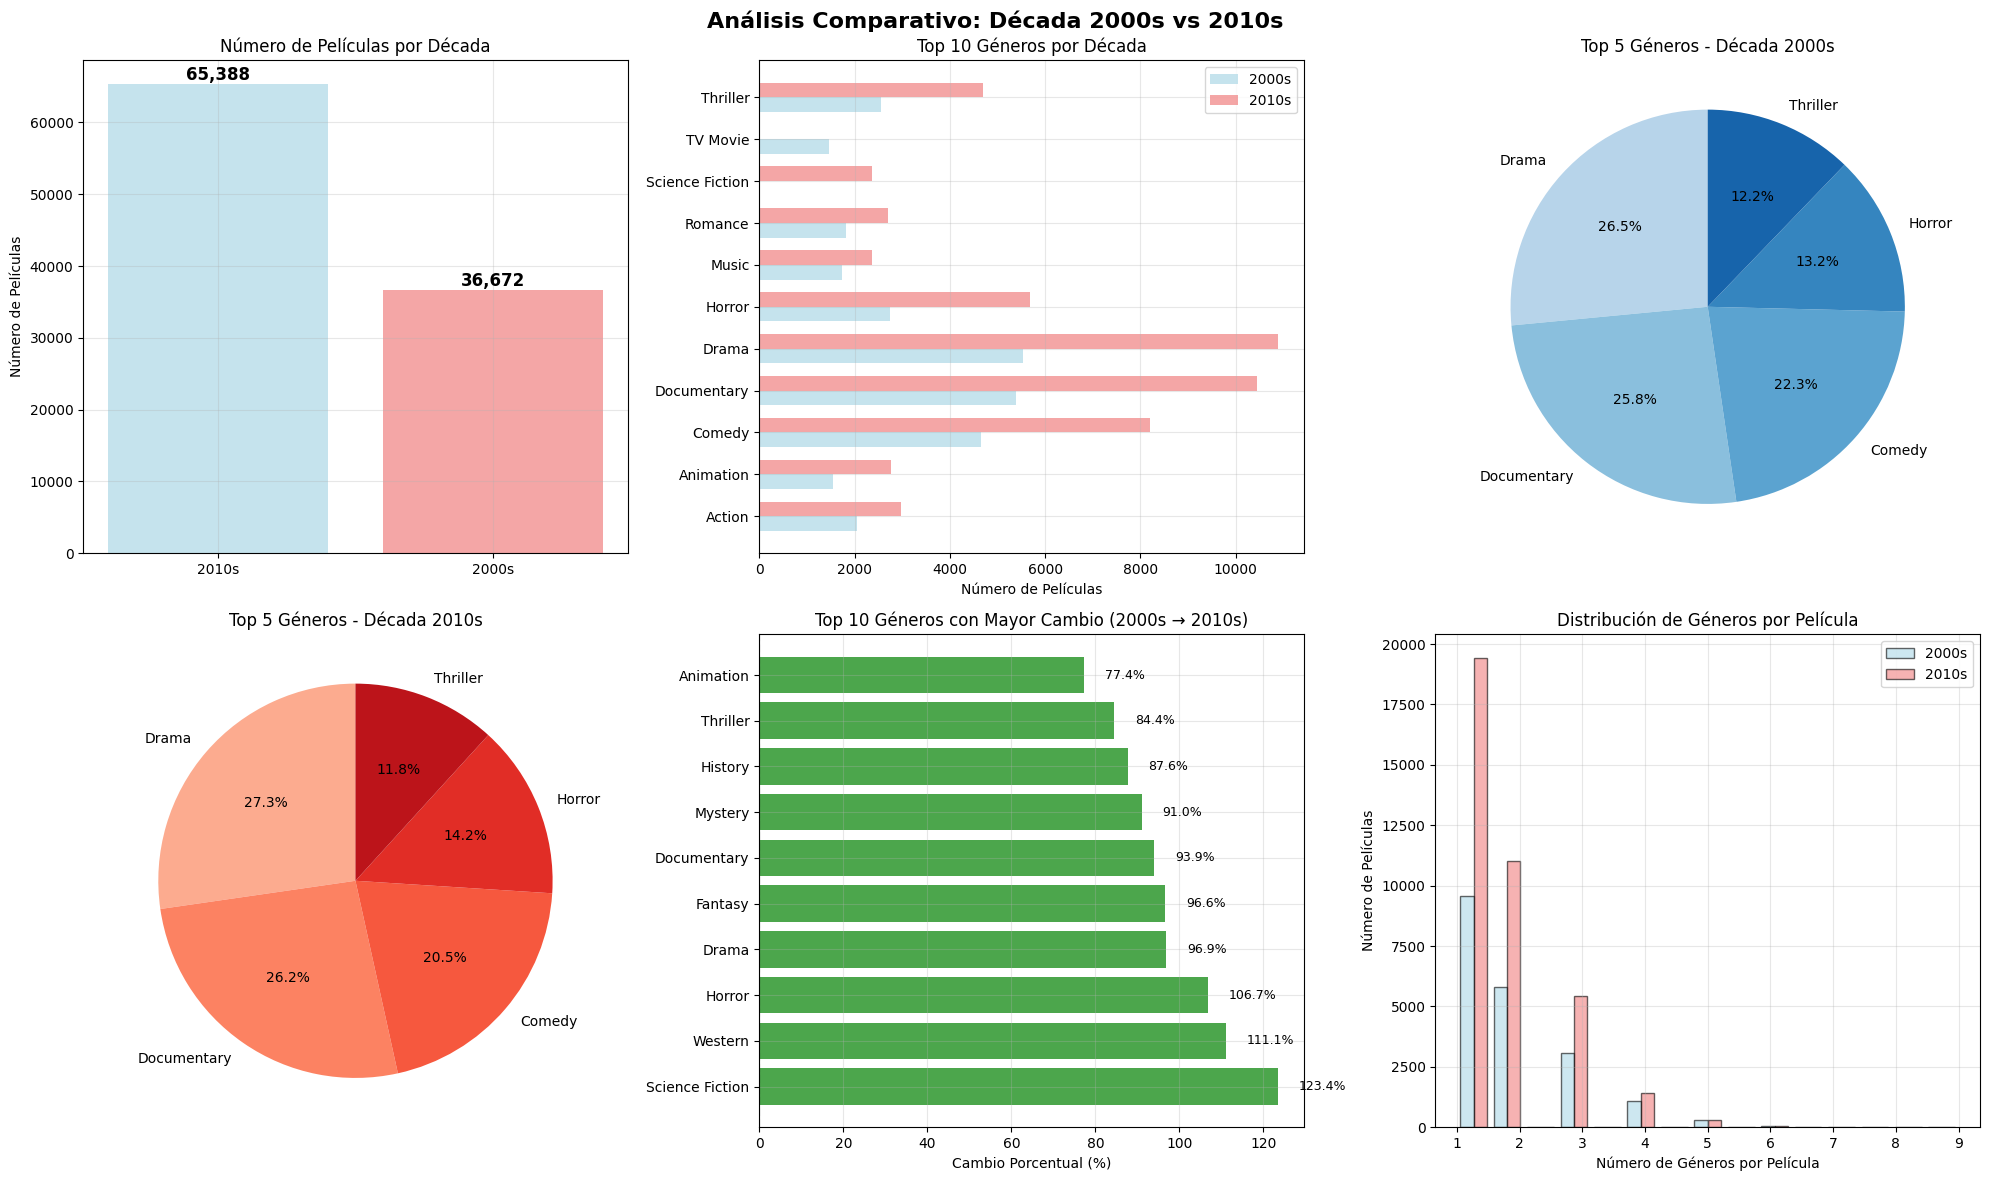

=== ANÁLISIS COMPARATIVO DETALLADO ===

PELÍCULAS:
2000s: 19,890 películas
2010s: 37,670 películas
Crecimiento: 89.4%

GÉNEROS:
Géneros únicos en 2000s: 19
Géneros únicos en 2010s: 19

GÉNEROS MÁS POPULARES:
2000s: ['Drama', 'Documentary', 'Comedy']
2010s: ['Drama', 'Documentary', 'Comedy']

GÉNEROS CON MAYOR CRECIMIENTO:
Science Fiction: 123.4% (1058 → 2364)
Western: 111.1% (144 → 304)
Horror: 106.7% (2750 → 5685)

GÉNEROS CON MAYOR DECLIVE:
Family: 44.5% (1373 → 1984)
TV Movie: 37.7% (1455 → 2003)
Music: 35.9% (1733 → 2356)

GÉNEROS POR PELÍCULA (PROMEDIO):
2000s: 1.84 géneros por película
2010s: 1.74 géneros por película


In [8]:
# Análisis comparativo detallado entre décadas 2000s y 2010s
# Esta sección compara directamente las dos décadas objetivo del análisis
# para identificar cambios en tendencias, géneros populares y patrones cinematográficos
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configuración de gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams['font.size'] = 10

# Preparar datos para análisis comparativo
# Separamos los datos por década para comparaciones directas
decade_2000s = final_df[final_df['decade'] == '2000s']
decade_2010s = final_df[final_df['decade'] == '2010s']

# Crear figura con subplots para análisis comparativo
# 6 gráficos que exploran diferentes aspectos de la comparación entre décadas
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Análisis Comparativo: Década 2000s vs 2010s', fontsize=16, fontweight='bold')

# 1. Conteo de películas por década
# Compara el volumen total de películas entre las dos décadas
# Azul = 2000s, Rojo = 2010s
decade_counts = final_df['decade'].value_counts()
colors = ['lightblue', 'lightcoral']
bars = axes[0,0].bar(decade_counts.index, decade_counts.values, color=colors, alpha=0.7)
axes[0,0].set_title('Número de Películas por Década')
axes[0,0].set_ylabel('Número de Películas')
axes[0,0].grid(True, alpha=0.3)

# Agregar valores numéricos en las barras
for i, v in enumerate(decade_counts.values):
    axes[0,0].text(i, v + 500, f'{v:,}', ha='center', fontsize=12, fontweight='bold')

# 2. Top 10 géneros por década - Comparación lado a lado
# Compara directamente los géneros más populares de cada década
# Permite identificar cambios en las preferencias cinematográficas
top_genres_2000s = decade_2000s['genre'].value_counts().head(10)
top_genres_2010s = decade_2010s['genre'].value_counts().head(10)

# Crear DataFrame para comparación
comparison_genres = pd.DataFrame({
    '2000s': top_genres_2000s,
    '2010s': top_genres_2010s
}).fillna(0)

# Gráfico de barras horizontal lado a lado
# Azul = 2000s, Rojo = 2010s
x = np.arange(len(comparison_genres.index))
width = 0.35

axes[0,1].barh(x - width/2, comparison_genres['2000s'], width, label='2000s', alpha=0.7, color='lightblue')
axes[0,1].barh(x + width/2, comparison_genres['2010s'], width, label='2010s', alpha=0.7, color='lightcoral')
axes[0,1].set_title('Top 10 Géneros por Década')
axes[0,1].set_xlabel('Número de Películas')
axes[0,1].set_yticks(x)
axes[0,1].set_yticklabels(comparison_genres.index)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Distribución de géneros - Gráfico de pastel comparativo
# Top 5 géneros para cada década
top5_2000s = decade_2000s['genre'].value_counts().head(5)
top5_2010s = decade_2010s['genre'].value_counts().head(5)

# Crear subplots para pasteles
ax1 = axes[0,2]
ax2 = axes[1,0]

# Pastel para 2000s
wedges1, texts1, autotexts1 = ax1.pie(top5_2000s.values, labels=top5_2000s.index, autopct='%1.1f%%', 
                                       startangle=90, colors=plt.cm.Blues(np.linspace(0.3, 0.8, len(top5_2000s))))
ax1.set_title('Top 5 Géneros - Década 2000s')

# Pastel para 2010s
wedges2, texts2, autotexts2 = ax2.pie(top5_2010s.values, labels=top5_2010s.index, autopct='%1.1f%%', 
                                       startangle=90, colors=plt.cm.Reds(np.linspace(0.3, 0.8, len(top5_2010s))))
ax2.set_title('Top 5 Géneros - Década 2010s')

# 4. Cambio en popularidad de géneros (2000s vs 2010s)
# Calcula el cambio porcentual en popularidad de cada género entre décadas
# Verde = crecimiento, Rojo = declive
all_genres = set(decade_2000s['genre'].unique()) | set(decade_2010s['genre'].unique())
genre_changes = []

for genre in all_genres:
    count_2000s = len(decade_2000s[decade_2000s['genre'] == genre])
    count_2010s = len(decade_2010s[decade_2010s['genre'] == genre])
    
    if count_2000s > 0:
        change_pct = ((count_2010s - count_2000s) / count_2000s) * 100
    else:
        change_pct = 100 if count_2010s > 0 else 0
    
    genre_changes.append({
        'genre': genre,
        'count_2000s': count_2000s,
        'count_2010s': count_2010s,
        'change_pct': change_pct
    })

changes_df = pd.DataFrame(genre_changes)
changes_df = changes_df.sort_values('change_pct', ascending=False)

# Top 10 géneros con mayor cambio (crecimiento o declive)
top_changes = changes_df.head(10)
colors = ['green' if x > 0 else 'red' for x in top_changes['change_pct']]

bars = axes[1,1].barh(range(len(top_changes)), top_changes['change_pct'], color=colors, alpha=0.7)
axes[1,1].set_title('Top 10 Géneros con Mayor Cambio (2000s → 2010s)')
axes[1,1].set_xlabel('Cambio Porcentual (%)')
axes[1,1].set_yticks(range(len(top_changes)))
axes[1,1].set_yticklabels(top_changes['genre'])
axes[1,1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
axes[1,1].grid(True, alpha=0.3)

# Agregar valores porcentuales en las barras
for i, v in enumerate(top_changes['change_pct']):
    axes[1,1].text(v + (5 if v > 0 else -5), i, f'{v:.1f}%', va='center', 
                   ha='left' if v > 0 else 'right', fontsize=9)

# 5. Distribución de géneros por película por década
movies_2000s = decade_2000s.groupby('id').size()
movies_2010s = decade_2010s.groupby('id').size()

# Crear histogramas comparativos
axes[1,2].hist([movies_2000s.values, movies_2010s.values], bins=15, alpha=0.6, 
               label=['2000s', '2010s'], color=['lightblue', 'lightcoral'], edgecolor='black')
axes[1,2].set_title('Distribución de Géneros por Película')
axes[1,2].set_xlabel('Número de Géneros por Película')
axes[1,2].set_ylabel('Número de Películas')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas comparativas detalladas
print("=== ANÁLISIS COMPARATIVO DETALLADO ===")
print(f"\nPELÍCULAS:")
print(f"2000s: {len(decade_2000s['id'].unique()):,} películas")
print(f"2010s: {len(decade_2010s['id'].unique()):,} películas")
print(f"Crecimiento: {((len(decade_2010s['id'].unique()) - len(decade_2000s['id'].unique())) / len(decade_2000s['id'].unique()) * 100):.1f}%")

print(f"\nGÉNEROS:")
print(f"Géneros únicos en 2000s: {decade_2000s['genre'].nunique()}")
print(f"Géneros únicos en 2010s: {decade_2010s['genre'].nunique()}")

print(f"\nGÉNEROS MÁS POPULARES:")
print("2000s:", list(top_genres_2000s.head(3).index))
print("2010s:", list(top_genres_2010s.head(3).index))

print(f"\nGÉNEROS CON MAYOR CRECIMIENTO:")
top_growth = changes_df.head(3)
for _, row in top_growth.iterrows():
    print(f"{row['genre']}: {row['change_pct']:.1f}% ({row['count_2000s']} → {row['count_2010s']})")

print(f"\nGÉNEROS CON MAYOR DECLIVE:")
top_decline = changes_df.tail(3)
for _, row in top_decline.iterrows():
    print(f"{row['genre']}: {row['change_pct']:.1f}% ({row['count_2000s']} → {row['count_2010s']})")

print(f"\nGÉNEROS POR PELÍCULA (PROMEDIO):")
print(f"2000s: {movies_2000s.mean():.2f} géneros por película")
print(f"2010s: {movies_2010s.mean():.2f} géneros por película")


1.  **Tipado y orden canónico**
    
    *   id → int64: asegura identificadores numéricos consistentes.
        
    *   decade → **Categorical ordenada** con categorías \["2000s","2010s"\]: fija el orden lógico (útil para sort, groupby, gráficos).
        
    *   genre → **Categorical**: reduce memoria y acelera operaciones sobre texto repetido.
        
    *   Ordena el dataset por \["decade","genre","id"\] y reinicia el índice para dejarlo limpio.
        
2.  **QA rápido (sanidad del dataset)**
    
    *   assert sin nulos en id y genre.
        
    *   assert que decade solo tenga valores esperados (2000s, 2010s).
        
    *   Verifica duplicados en la clave analítica **(id, genre, decade)** y reporta si hay (debería ser 0 tras la deduplicación previa).
        
3.  **Inspección y persistencia**
    
    *   Imprime los dtypes finales (para auditar el esquema).
        
    *   **Guarda** una versión **limpia y columnar** en **Parquet** (final\_df\_us\_2000s\_2010s.parquet), formato eficiente (compresión, esquema, lectura rápida) para los análisis posteriores del **Top-3 por década** y pruebas estadísticas